Son necesarias las librerias numpy, matplotlib, PySpice y ipywidgets

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

In [31]:
# Texto en el botón
button = widgets.Button(description="Guardar imagen")

# Texto indicando el nombre a asignar a la imagen junto a la caja de texto
Text = widgets.Text(
    value='',
    description='Nombre de la imagen:',
    disabled=False,
    style= {'description_width': 'initial'}
)

# Botón para guardar la imagen, utilizando el texto que se ha escrito en la caja de texto como nombre
@button.on_click
def on_button_clicked(rest):
    global figure
    figure.savefig(Text.value + ".png")

Señal cuadrada circuito RL y RC con salida en L y C

In [32]:
# Plot interactivo
def interactive_plot(pwidth):

    global figure
    figure, ax = plt.subplots(1, 1, figsize=(7, 4))

    # Circuito 1. RL con salida en L aplicando una señal cuadrada de entrada
    circuit = Circuit('RL con salida en L. Señal cuadrada')

    # Se definen los elementos
    source = circuit.PulseVoltageSource(1, 'in', circuit.gnd, initial_value=0@u_V, pulsed_value=10@u_V,
                           pulse_width=pwidth@u_ms, period=2*pwidth@u_ms)
    circuit.R(1, 'in', 'out', 220@u_Ω)
    circuit.L(1, 'out', circuit.gnd, 10@u_mH)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=source.period/200, end_time=source.period)

    # Circuito 2. RC con salida en C aplicando una señal cuadrada de entrada
    circuit2 = Circuit('RC con salida en C. Señal cuadrada')

    # Se definen los elementos
    source2 = circuit2.PulseVoltageSource(1, 'in', circuit.gnd, initial_value=0@u_V, pulsed_value=10@u_V,
                           pulse_width=pwidth@u_ms, period=2*pwidth@u_ms)
    circuit2.R(1, 'in', 'out', 220@u_Ω)
    circuit2.C(1, 'out', circuit.gnd, 100@u_nF)

    # Se simula y analiza el circuito
    simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
    analysis2 = simulator2.transient(step_time=source2.period/200, end_time=source2.period)

    # Función teórica
    t=np.array(analysis.time)
    Vf=10
    tau=220*100*10**(-9)
    v_s=Vf*(1-np.exp(-(t[:115]-10**(-6))/tau))

    # Gráfica
    ax.set_title('RL con salida en L y RC con salida en C. Señal cuadrada')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['in'])
    ax.plot(analysis.time*1000, analysis['out'])
    ax.plot(analysis2.time*1000, analysis2['out'])
    ax.plot(t[:115]*1000, v_s)
    ax.legend(('input', 'salida en L', 'salida en C', 'respuesta a la entrada teórica'), loc=(.05,.1))
    ax.set_ylim(float(-source.pulsed_value*1.1), float(source.pulsed_value*1.1))

# Slider que varía la anchura y el periodo del pulso
sliderPulse_Width = widgets.FloatSlider(
    value=0.25, 
    min=0.01, 
    max=0.3, 
    step=0.005,
    description='Pulse width',
    readout=True,
    readout_format='.3f',
    layout=widgets.Layout(width='500px')
)
# Llama al plot y los sliders
interact(interactive_plot, pwidth=sliderPulse_Width)
# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=0.25, description='Pulse width', layout=Layout(width='500px'), max=0.3…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

Respuesta natural RL y RC

In [33]:
# Plot interactivo
def interactive_plot(finaltime):
    # Respuesta al estado en un circuito RL
    circuit = Circuit('Respuesta al estado. Circuito RL')

    # Se definen los elementos
    # Interruptor
    circuit.model('switch', 'SW', Ron=1@u_mΩ, Roff=1@u_GΩ)
    circuit.PulseVoltageSource(2, 'a', circuit.gnd,initial_value=1, pulsed_value=-1,
                           pulse_width=finaltime@u_us, period=finaltime@u_us, delay_time=1@u_us)

    circuit.PulseVoltageSource(3, 'b', circuit.gnd,initial_value=-1, pulsed_value=1,
                           pulse_width=finaltime@u_us, period=finaltime@u_us, delay_time=1@u_us)
    circuit.V(1, 1, circuit.gnd,   1@u_V)
    circuit.VoltageControlledSwitch(1, 1, 'output', 'a', circuit.gnd, model='switch')
    circuit.L(1, 'output', circuit.gnd, 10@u_mH)
    circuit.VoltageControlledSwitch(2, 'output', 2, 'b', circuit.gnd, model='switch')
    circuit.R(2, 2, circuit.gnd,           220@u_Ω)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    ic=0@u_V
    simulator.initial_condition(output=ic)
    analysis = simulator.transient(step_time=0.01@u_us, end_time=finaltime@u_us)

    # Función teórica
    time=np.array(analysis.time)
    tau=0.01/220
    i_s=np.max(analysis['L1']*1000)*np.exp(-(time-10**(-6))/tau)

    # Gráfica
    global figure
    figure, ax = plt.subplots(figsize=(7, 4))

    ax.set_title('Respuesta al estado. Circuito RL')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Intensidad [mA]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['L1']*1000)
    ax.plot(time*1000, i_s)
    ax.legend(('output', 'teórico'), loc=(.05,.1))

# Slider que varía el tiempo final
sliderFinal = widgets.FloatSlider(
    value=227, 
    min=100, 
    max=250, 
    step=0.1,
    description='Final',
    readout=True,
    readout_format='.3f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(interactive_plot, finaltime=sliderFinal)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=227.0, description='Final', layout=Layout(width='500px'), max=250.0, m…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

In [34]:
# Plot interactivo
def interactive_plot(steptime, finaltime):
    # Respuesta al estado en un circuito RC
    circuit = Circuit('Respuesta al estado. Circuito RC')

    # Se definen los elementos
    # Interruptor
    circuit.model('switch', 'SW', Ron=1@u_mΩ, Roff=1@u_GΩ)
    circuit.PulseVoltageSource(2, 'a', circuit.gnd, initial_value=1, pulsed_value=-1,
                           pulse_width=finaltime@u_us, period=finaltime@u_us, delay_time=1@u_ns)
    circuit.PulseVoltageSource(3, 'b', circuit.gnd, initial_value=-1, pulsed_value=1,
                           pulse_width=finaltime@u_us, period=finaltime@u_us, delay_time=1@u_ns)
    circuit.V(1, 1, circuit.gnd,   1@u_V)
    circuit.VoltageControlledSwitch(1, 1, 'output', 'a', circuit.gnd, model='switch')
    circuit.C(1, 'output', circuit.gnd, 10@u_nF)
    circuit.VoltageControlledSwitch(2, 'output', 2, 'b', circuit.gnd, model='switch')
    circuit.R(2, 2, circuit.gnd,           220@u_Ω)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    ic=0@u_V
    simulator.initial_condition(output=ic)
    analysis = simulator.transient(step_time=steptime@u_us, end_time=finaltime@u_us)

    # Función teórica
    t=np.array(analysis.time)
    Vi=1
    tau=220*10*10**(-9)
    v_s=Vi*np.exp(-(t-10**(-9))/tau)

    # Gráfica
    global figure
    figure, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Respuesta al estado. Circuito RC')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['output'])
    ax.plot(t*1000, v_s)
    ax.legend(('output', 'teórico'), loc=(.05,.1))

# Slider que varía el intervalo de tiempo entre puntos
sliderStep = widgets.FloatSlider(
    value=0.01, 
    min=0.01, 
    max=3, 
    step=0.01,
    description='Step',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)
# Slider que varía el tiempo final
sliderFinal = widgets.FloatSlider(
    value=8, 
    min=5, 
    max=12, 
    step=0.1,
    description='Final',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(interactive_plot, steptime=sliderStep, finaltime=sliderFinal)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=0.01, description='Step', layout=Layout(width='500px'), max=3.0, min=0…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

Diagrama de Bode de un circuito RL con salida en R y en L

[Text(0, -3.141592653589793, '$-\\pi$'),
 Text(0, -1.5707963267948966, '$-\\frac{\\pi}{2}$'),
 Text(0, 0.0, '0'),
 Text(0, 1.5707963267948966, '$\\frac{\\pi}{2}$'),
 Text(0, 3.141592653589793, '$\\pi$')]

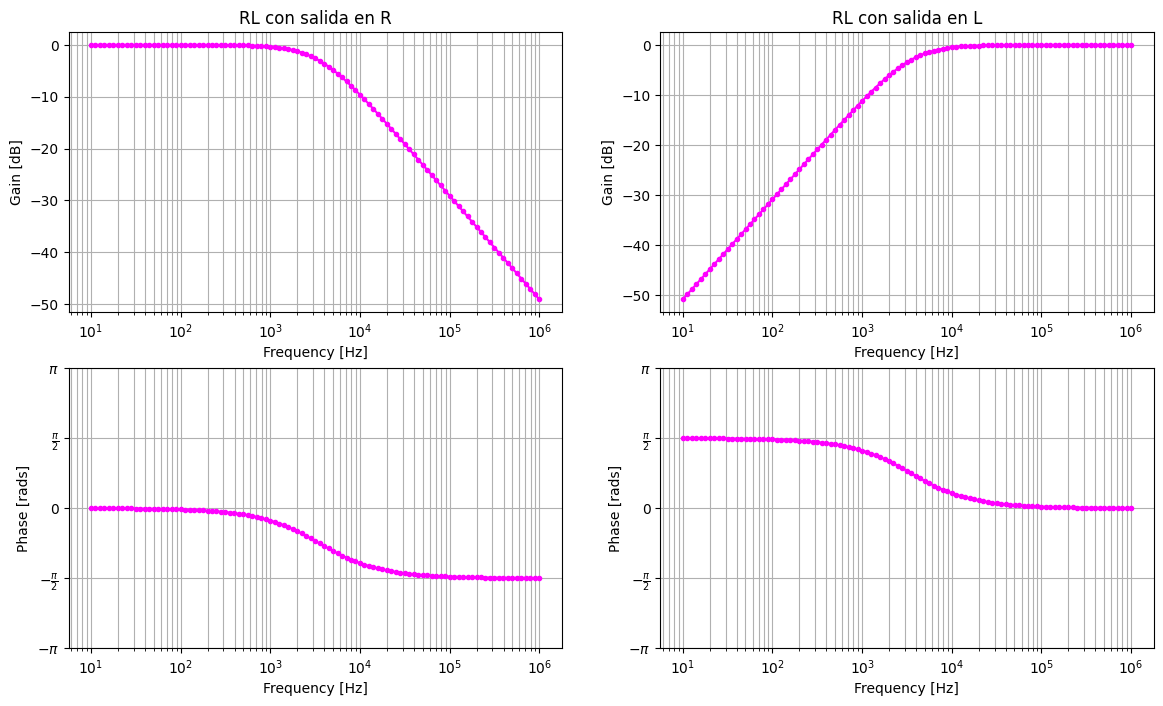

In [35]:
figure, axes = plt.subplots(2, 2, figsize=(14, 8))

# Circuito 1. RL con salida en R
circuit = Circuit('RL con salida en R')

# Se definen los elementos
source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit.L(1, 'in', 'out', 10@u_mH)
circuit.R(1, 'out', circuit.gnd, 220@u_Ω)

# Se simula y analiza el circuito
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_Hz, stop_frequency=1@u_MHz, number_of_points=20,  variation='dec')

# Circuito 2. RL con salida en L
circuit2 = Circuit('RL con salida en L')

# Se definen los elementos
source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit2.R(1, 'in', 'out', 220@u_Ω)
circuit2.L(1, 'out', circuit.gnd, 10@u_mH)

# Se simula y analiza el circuito
simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
analysis2 = simulator2.ac(start_frequency=10@u_Hz, stop_frequency=1@u_MHz, number_of_points=20,  variation='dec')

# Se realizan los diagramas de Bode para ambos circuitos
bode_diagram(axes=(axes[0,0],axes[1,0]),
             frequency=analysis.frequency,
             gain=20*np.log10(np.absolute(analysis['out'])),
             phase=np.angle(analysis['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,0].set_title('RL con salida en R')
bode_diagram(axes=(axes[0,1],axes[1,1]),
             frequency=analysis2.frequency,
             gain=20*np.log10(np.absolute(analysis2['out'])),
             phase=np.angle(analysis2['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,1].set_title('RL con salida en L')
axes[1,0].set_ylim(-np.pi, np.pi)
axes[1,0].set_yticks(np.linspace(-np.pi, np.pi, 5))
axes[1,0].set_yticklabels(axes[1,1].get_yticklabels())

Diagrama de Bode de un circuito RC con salida en C

[Text(0, -3.141592653589793, '$-\\pi$'),
 Text(0, -1.5707963267948966, '$-\\frac{\\pi}{2}$'),
 Text(0, 0.0, '0'),
 Text(0, 1.5707963267948966, '$\\frac{\\pi}{2}$'),
 Text(0, 3.141592653589793, '$\\pi$')]

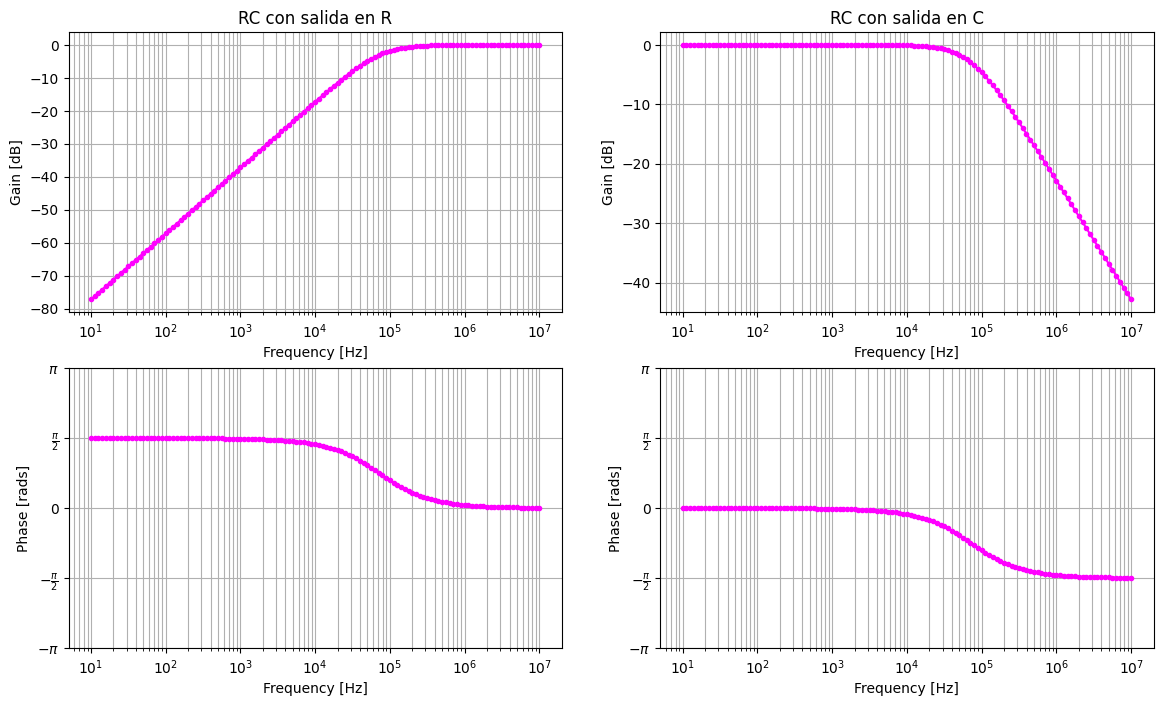

In [36]:
figure, axes = plt.subplots(2, 2, figsize=(14, 8))

# Circuito 1. RC con salida en R
circuit = Circuit('RC con salida en R')

# Se definen los elementos
source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit.C(1, 'in', 'out', 10@u_nF)
circuit.R(1, 'out', circuit.gnd, 220@u_Ω)

# Se simula y analiza el circuito
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_MHz, number_of_points=20,  variation='dec')

# Circuito 2. RC con salida en C
circuit2 = Circuit('RC con salida en C')

# Se definen los elementos
source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V)
circuit2.R(1, 'in', 'out', 220@u_Ω)
circuit2.C(1, 'out', circuit.gnd, 10@u_nF)

# Se simula y analiza el circuito
simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
analysis2 = simulator2.ac(start_frequency=10@u_Hz, stop_frequency=10@u_MHz, number_of_points=20,  variation='dec')

# Se realizan los diagramas de Bode para ambos circuitos
bode_diagram(axes=(axes[0,0],axes[1,0]),
             frequency=analysis.frequency,
             gain=20*np.log10(np.absolute(analysis['out'])),
             phase=np.angle(analysis['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,0].set_title('RC con salida en R')
bode_diagram(axes=(axes[0,1],axes[1,1]),
             frequency=analysis2.frequency,
             gain=20*np.log10(np.absolute(analysis2['out'])),
             phase=np.angle(analysis2['out'], deg=False),
             marker='.',
             color='magenta',
             linestyle='-'
            )
axes[0,1].set_title('RC con salida en C')
axes[1,0].set_ylim(-np.pi, np.pi)
axes[1,0].set_yticks(np.linspace(-np.pi, np.pi, 5))
axes[1,0].set_yticklabels(axes[1,1].get_yticklabels())

Voltaje de salida en R y en L de un circuito RL

In [37]:
# Plot interactivo
def plot(freqR, freqL):
    global figure
    figure, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 10))

    # Circuito 1. RL con salida en R
    circuit = Circuit('RL con salida en R')

    # Se definen los elementos
    source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqR@u_kHz)
    circuit.L(1, 'in', 'out', 10@u_mH)
    circuit.R(1, 'out', circuit.gnd, 220@u_Ω)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)

    # Gráfica
    ax.set_title('RL con salida en R')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['in'])
    ax.plot(analysis.time*1000, analysis['out'])
    ax.legend(('input', 'output'), loc=(.05,.1))
    ax.set_ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))

    # Circuito 2. RL con salida en L
    circuit2 = Circuit('RL con salida en L')

    # Se definen los elementos
    source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqL@u_kHz)
    circuit2.R(1, 'in', 'out', 220@u_Ω)
    circuit2.L(1, 'out', circuit.gnd, 10@u_mH)

    # Se simula y analiza el circuito
    simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
    analysis2 = simulator2.transient(step_time=source2.period/200, end_time=source2.period*2)

    # Gráfica
    ax2.set_title('RL con salida en L')
    ax2.set_xlabel('Tiempo [ms]')
    ax2.set_ylabel('Voltaje [V]')
    ax2.grid()
    ax2.plot(analysis2.time*1000, analysis2['in'])
    ax2.plot(analysis2.time*1000, analysis2['out'])
    ax2.legend(('input', 'output'), loc=(.05,.1))
    ax2.set_ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))

# Slider frecuencia del circuito 1
sliderR = widgets.FloatSlider(
    value=5, 
    min=0.01, 
    max=10, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)
# Slider frecuencia del circuito 2
sliderL = widgets.FloatSlider(
    value=5, 
    min=0.01, 
    max=10, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)
# Llama al plot y los sliders
interact(plot, freqR=sliderR, freqL=sliderL)
# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=5.0, description='freqR', layout=Layout(width='500px'), max=10.0, min=…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())

Voltaje de salida en R y en C de un circuito RC

In [38]:
# Plot interactivo
def plot(freqR, freqC):
    global figure
    figure, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 10))

    # Circuito 1. RC con salida en R
    circuit = Circuit('RC con salida en R')

    # Se definen los elementos
    source = circuit.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqR@u_kHz)
    circuit.C(1, 'in', 'out', 10@u_nF)
    circuit.R(1, 'out', circuit.gnd, 220@u_Ω)

    # Se simula y analiza el circuito
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)

    # Gráfica
    ax.set_title('RC con salida en R')
    ax.set_xlabel('Tiempo [ms]')
    ax.set_ylabel('Voltaje [V]')
    ax.grid()
    ax.plot(analysis.time*1000, analysis['in'])
    ax.plot(analysis.time*1000, analysis['out'])
    ax.legend(('input', 'output'), loc=(.05,.1))
    ax.set_ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))

    # Circuito 2. RC con salida en C
    circuit2 = Circuit('RC con salida en C')

    # Se definen los elementos
    source2 = circuit2.SinusoidalVoltageSource(1, 'in', circuit.gnd, amplitude=10@u_V, frequency=freqC@u_kHz)
    circuit2.R(1, 'in', 'out', 220@u_Ω)
    circuit2.C(1, 'out', circuit.gnd, 10@u_nF)

    # Se simula y analiza el circuito
    simulator2 = circuit2.simulator(temperature=25, nominal_temperature=25)
    analysis2 = simulator2.transient(step_time=source2.period/200, end_time=source2.period*2)

    # Gráfica
    ax2.set_title('RC con salida en C')
    ax2.set_xlabel('Tiempo [ms]')
    ax2.set_ylabel('Voltaje [V]')
    ax2.grid()
    ax2.plot(analysis2.time*1000, analysis2['in'])
    ax2.plot(analysis2.time*1000, analysis2['out'])
    ax2.legend(('input', 'output'), loc=(.05,.1))
    ax2.set_ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))

# Slider frecuencia del circuito 1
sliderR = widgets.FloatSlider(
    value=60, 
    min=15, 
    max=200, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)
# Slider frecuencia del circuito 2
sliderL = widgets.FloatSlider(
    value=60, 
    min=15, 
    max=200, 
    step=0.01,
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='500px')
)

# Llama al plot y los sliders
interact(plot, freqR=sliderR, freqC=sliderL)

# Llama a la caja de texto y el botón de guardar imagen
display(Text, button)

interactive(children=(FloatSlider(value=60.0, description='freqR', layout=Layout(width='500px'), max=200.0, mi…

Text(value='', description='Nombre de la imagen:', style=TextStyle(description_width='initial'))

Button(description='Guardar imagen', style=ButtonStyle())